Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if
from facts.fairness_metrics_aggr import get_diff_table, get_comb_df, get_analysis_dfs, get_diff_real_diff_drop

In [2]:
from pathlib import Path

computed_rules_file = Path("..") / ".." / "Pre-computed Results" / "Adult" / "rulesAdult_sex_atomic.data"
computed_rules_with_cumulative_file = Path("..") / ".." / "Pre-computed Results" / "Adult" / "rulesAdult_sex_cumulative.data"

cost_budget = 10
top_count = 20
c_inf = 5

# Dataset Loading and Preprocessing

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


In [4]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = ['hours-per-week']

# Load Computed Rules

In [5]:
rules_with_atomic_correctness = load_rules_by_if(computed_rules_file)
rules_with_cumulative_correctness = load_rules_by_if(computed_rules_with_cumulative_file)

# Define Feature Weights

In [6]:
num_features = ['education-num', 'capital-gain', 'capital-loss']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

# Macro Viewpoint

## Equal Cost of Effectiveness (Macro)

In [7]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Cost of Effectiveness (Macro) (threshold = 0.7)'
)

If Workclass =  Private, education-num = 13, marital-status =  Never-married, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.48% covered
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 71.08%.
		Aggregate cost of the above recourses = 12.00
	Protected Subgroup ' Female', 3.78% covered
		Make Workclass =  Self-emp-inc, education-num = 15, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 77.07%.
		Aggregate cost of the above recourses = 18.00
	Bias against  Female due to Equal Cost of Effectiveness (Macro) (threshold = 0.7). Unfairness score = 6.
If Workclass =  Private, marital-status =  Never-married, native-country =  United-States, occupation =  Prof-specialty, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.49% covered
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with effecti

## Equal Choice for Recourse(Macro)

In [8]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=top_count,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Choice for Recourse(Macro) (threshold = 0.7)'
)

If Workclass =  Private, hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Male', 1.04% covered
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 70.00%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 70.00%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 70.00%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with effectiveness 70.00%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 80.00%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 70.00%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Sales with effectiveness 70.00%.
		Make Workclass =  Self-emp-inc, hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 81.43%.
		Aggregate cost of t

# Micro Viewpoint

##  Equal Conditional Mean Recourse

If native-country =  United-States, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.27% covered
		Make relationship =  Married with effectiveness 2.65% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 2.65% and counterfactual cost = 100.0.
		Make race =  White, relationship =  Married with effectiveness 3.97% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 38.33
	Protected Subgroup ' Female', 4.02% covered
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 0.00% and counterfactual cost = 100.0.
		Make race =  White, relationship =  Married with effectiveness 0.72% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 105.00
	Bias against  Female due to Equal Conditional Mean Recourse. Unfairness score = 66.667.
	Cumulative effectiveness plot for the above recourses:


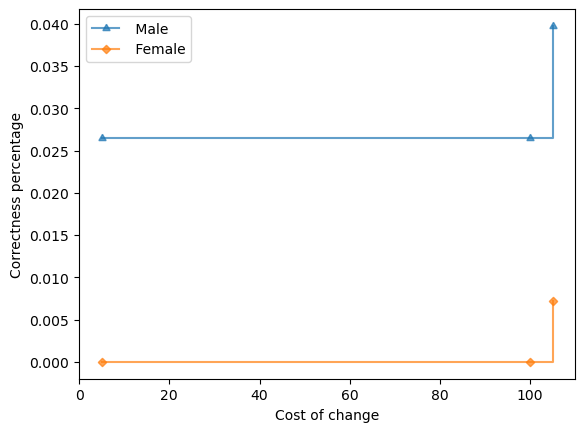

If age = (34.0, 41.0], race =  Black:
	Protected Subgroup ' Male', 1.36% covered
		Make age = (41.0, 50.0] with effectiveness 2.02% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 3.03% and counterfactual cost = 100.0.
		Make age = (50.0, 90.0], race =  White with effectiveness 4.04% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  Asian-Pac-Islander with effectiveness 4.04% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  White with effectiveness 5.05% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 68.00
	Protected Subgroup ' Female', 3.13% covered
		Make age = (41.0, 50.0] with effectiveness 0.86% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 0.86% and counterfactual cost = 100.0.
		Make age = (41.0, 50.0], race =  White with effectiveness 0.86% and counterfactual cost = 110.0.
		Make age = (50.0, 90.0], race =  White with effectiveness 0.86% and counterfactual cost = 1

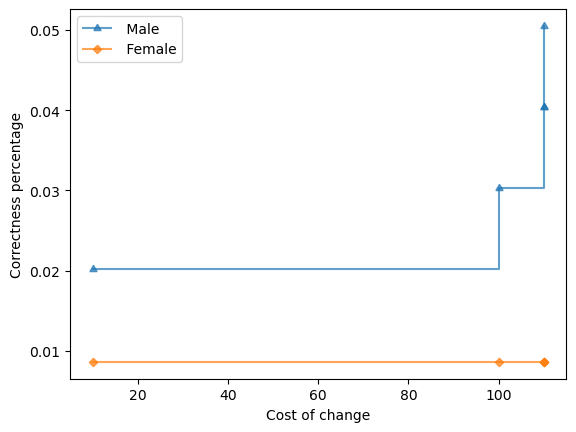

If age = (26.0, 34.0], race =  Black:
	Protected Subgroup ' Male', 2.02% covered
		Make age = (41.0, 50.0] with effectiveness 3.40% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 3.40% and counterfactual cost = 100.0.
		Make age = (34.0, 41.0], race =  White with effectiveness 4.76% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  Asian-Pac-Islander with effectiveness 4.76% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  White with effectiveness 7.48% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 64.55
	Protected Subgroup ' Female', 3.46% covered
		Make age = (41.0, 50.0] with effectiveness 2.65% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 2.65% and counterfactual cost = 100.0.
		Make age = (34.0, 41.0], race =  White with effectiveness 2.65% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  Asian-Pac-Islander with effectiveness 2.65% and counterfac

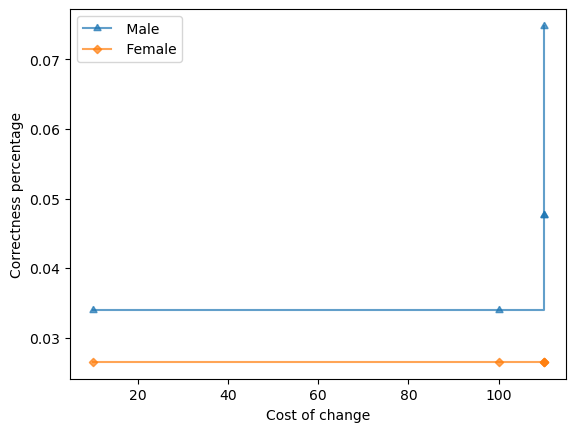

If occupation =  Other-service, race =  Black:
	Protected Subgroup ' Male', 1.40% covered
		Make occupation =  Prof-specialty with effectiveness 4.04% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair, race =  White with effectiveness 4.04% and counterfactual cost = 104.0.
		Make occupation =  Adm-clerical, race =  White with effectiveness 4.04% and counterfactual cost = 104.0.
		Make occupation =  Transport-moving, race =  White with effectiveness 4.04% and counterfactual cost = 104.0.
		Make occupation =  Sales, race =  White with effectiveness 5.05% and counterfactual cost = 104.0.
		Make occupation =  Prof-specialty, race =  Asian-Pac-Islander with effectiveness 5.05% and counterfactual cost = 104.0.
		Make occupation =  Protective-serv, race =  White with effectiveness 5.05% and counterfactual cost = 104.0.
		Make occupation =  Tech-support, race =  White with effectiveness 7.07% and counterfactual cost = 104.0.
		Make occupation =  Prof-specialty, race =  White wit

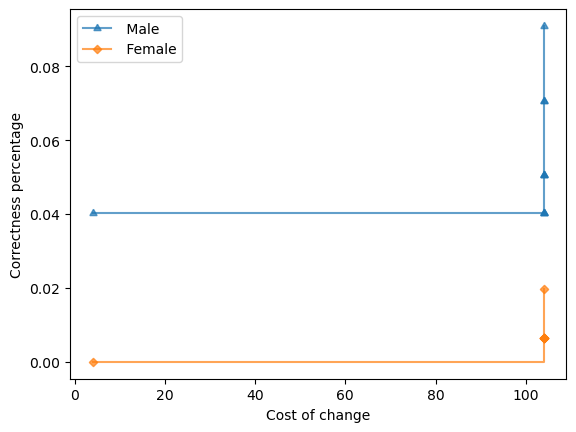

If hours-per-week = FullTime, native-country =  United-States, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.51% covered
		Make relationship =  Married with effectiveness 2.04% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 2.04% and counterfactual cost = 100.0.
		Make hours-per-week = OverTime, race =  White with effectiveness 2.04% and counterfactual cost = 102.0.
		Make race =  White, relationship =  Married with effectiveness 3.06% and counterfactual cost = 105.0.
		Make hours-per-week = MidTime, race =  White, relationship =  Married with effectiveness 3.06% and counterfactual cost = 107.0.
		Make hours-per-week = OverTime, race =  White, relationship =  Married with effectiveness 4.08% and counterfactual cost = 107.0.
		Make hours-per-week = PartTime, race =  White, relationship =  Married with effectiveness 4.08% and counterfactual cost = 109.0.
		Make hours-per-week = BrainDrain, race =  White, relationship =  Married with 

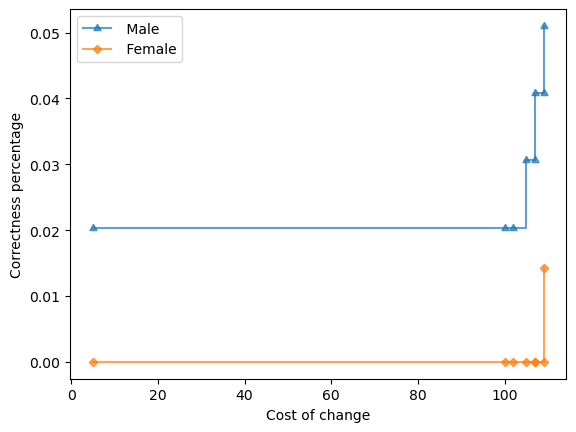

If marital-status =  Never-married, race =  Black, relationship =  Own-child:
	Protected Subgroup ' Male', 1.54% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.75% and counterfactual cost = 10.0.
		Make race =  White, relationship =  Not-in-family with effectiveness 1.75% and counterfactual cost = 105.0.
		Make marital-status =  Divorced, race =  White, relationship =  Not-in-family with effectiveness 1.75% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 2.63% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 2.63% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 43.33
	Protected Subgroup ' Female', 2.02% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.47% and counterfactual co

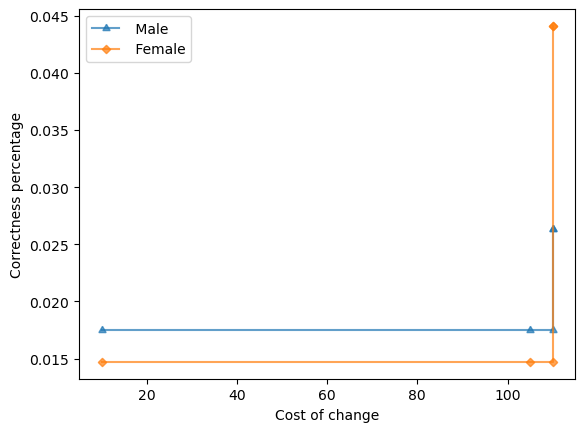

If marital-status =  Never-married, race =  Black:
	Protected Subgroup ' Male', 3.73% covered
		Make marital-status =  Married-civ-spouse with effectiveness 1.99% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 1.99% and counterfactual cost = 100.0.
		Make marital-status =  Divorced, race =  White with effectiveness 1.99% and counterfactual cost = 105.0.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander with effectiveness 2.39% and counterfactual cost = 105.0.
		Make marital-status =  Married-civ-spouse, race =  White with effectiveness 2.79% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 33.57
	Protected Subgroup ' Female', 7.34% covered
		Make marital-status =  Married-civ-spouse with effectiveness 1.06% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 1.06% and counterfactual cost = 100.0.
		Make marital-status =  Divorced, race =  White with effectiveness 1.06% and counterfactual cost = 1

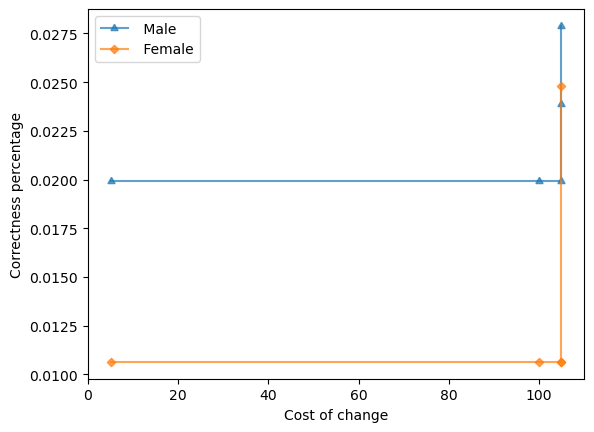

If marital-status =  Never-married, native-country =  United-States, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.30% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 8.89% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 8.89% and counterfactual cost = 100.0.
		Make marital-status =  Divorced, race =  White with effectiveness 8.89% and counterfactual cost = 105.0.
		Make marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 21.11% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 67.89
	Protected Subgroup ' Female', 2.19% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 13.16% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 13.16% and counterfactual cost = 100.0.
		Make marital-status =  Divorced, race =  White with effectiveness 13.16% and counterf

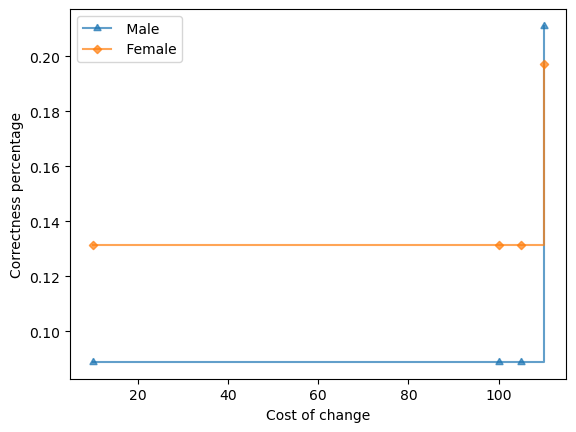

If Workclass =  Private, marital-status =  Never-married, native-country =  United-States, race =  Black:
	Protected Subgroup ' Male', 2.87% covered
		Make marital-status =  Married-civ-spouse with effectiveness 0.52% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 0.52% and counterfactual cost = 100.0.
		Make marital-status =  Divorced, race =  White with effectiveness 0.52% and counterfactual cost = 105.0.
		Make marital-status =  Married-civ-spouse, race =  White with effectiveness 1.04% and counterfactual cost = 105.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.04% and counterfactual cost = 107.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.04% and counterfactual cost = 107.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.04% and counterfactual cost = 107.0.
		Make Workclass =

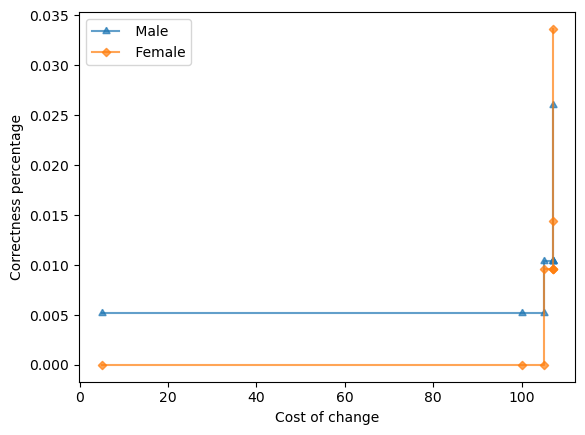

If age = (26.0, 34.0], education-num = 9, relationship =  Own-child:
	Protected Subgroup ' Male', 1.36% covered
		Make relationship =  Married with effectiveness 1.10% and counterfactual cost = 5.0.
		Make age = (34.0, 41.0], relationship =  Married with effectiveness 1.10% and counterfactual cost = 15.0.
		Make age = (41.0, 50.0], relationship =  Married with effectiveness 1.10% and counterfactual cost = 15.0.
		Make age = (41.0, 50.0], education-num = 10, relationship =  Married with effectiveness 1.10% and counterfactual cost = 18.0.
		Make age = (34.0, 41.0], education-num = 10, relationship =  Married with effectiveness 1.10% and counterfactual cost = 18.0.
		Make age = (34.0, 41.0], education-num = 11, relationship =  Married with effectiveness 1.10% and counterfactual cost = 21.0.
		Make age = (41.0, 50.0], education-num = 11, relationship =  Married with effectiveness 1.10% and counterfactual cost = 21.0.
		Aggregate cost of the above recourses = 5.00
	Protected Subgroup ' Fema

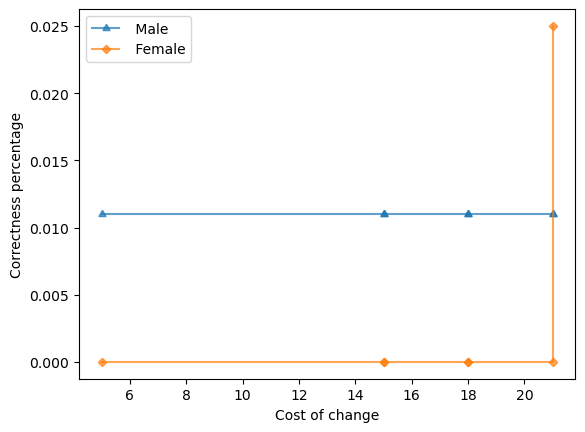

If Workclass =  Private, marital-status =  Never-married, race =  Black, relationship =  Own-child:
	Protected Subgroup ' Male', 1.25% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.03% and counterfactual cost = 10.0.
		Make race =  White, relationship =  Not-in-family with effectiveness 1.03% and counterfactual cost = 105.0.
		Make marital-status =  Divorced, race =  White, relationship =  Not-in-family with effectiveness 1.03% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 2.06% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 2.06% and counterfactual cost = 110.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 2.06% and counterfactual cost = 112.0.
		Make Workcl

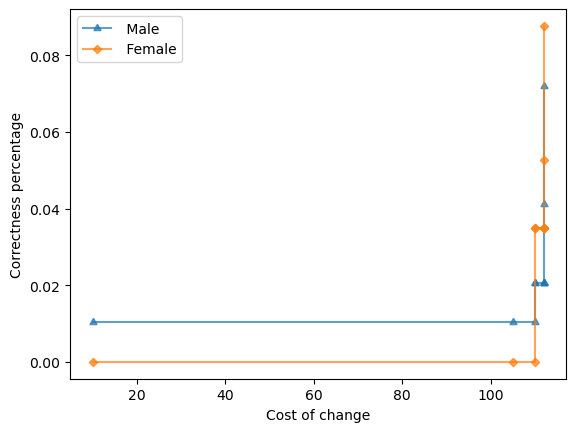

If marital-status =  Never-married, race =  Asian-Pac-Islander:
	Protected Subgroup ' Male', 1.12% covered
		Make marital-status =  Married-civ-spouse with effectiveness 6.15% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 6.15% and counterfactual cost = 100.0.
		Make marital-status =  Divorced, race =  White with effectiveness 6.15% and counterfactual cost = 105.0.
		Make marital-status =  Married-civ-spouse, race =  Black with effectiveness 6.15% and counterfactual cost = 105.0.
		Make marital-status =  Married-civ-spouse, race =  White with effectiveness 7.69% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 25.00
	Protected Subgroup ' Female', 1.56% covered
		Make marital-status =  Married-civ-spouse with effectiveness 2.86% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 2.86% and counterfactual cost = 100.0.
		Make marital-status =  Divorced, race =  White with effectiveness 2.86% and counterfactual cost = 1

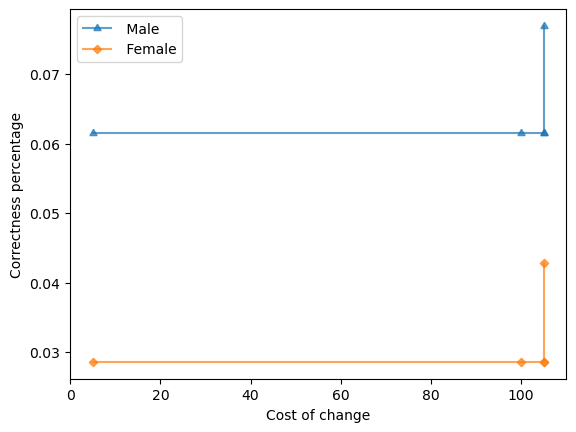

If capital-loss = 0, native-country =  United-States, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.22% covered
		Make relationship =  Married with effectiveness 2.03% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 2.03% and counterfactual cost = 100.0.
		Make race =  White, relationship =  Married with effectiveness 3.38% and counterfactual cost = 105.0.
		Make capital-loss = 1887, race =  White, relationship =  Married with effectiveness 15.54% and counterfactual cost = 105.48.
		Make capital-loss = 1902, race =  White, relationship =  Married with effectiveness 15.54% and counterfactual cost = 105.49.
		Make capital-loss = 1977, race =  White, relationship =  Married with effectiveness 15.54% and counterfactual cost = 105.51.
		Aggregate cost of the above recourses = 92.34
	Protected Subgroup ' Female', 3.95% covered
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make race =  White with 

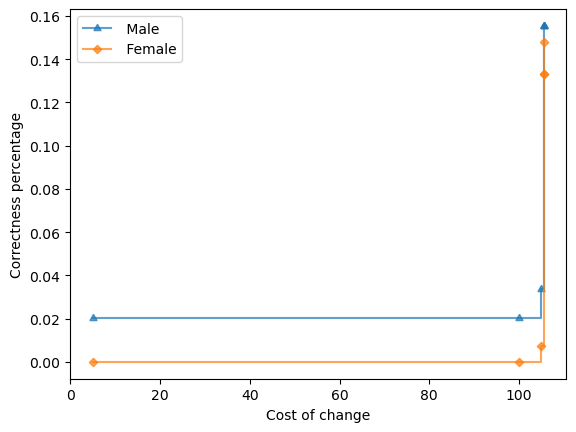

In [9]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    metric_name = 'Equal Conditional Mean Recourse'
)

## Equal Cost of Effectiveness (Micro)

In [10]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cor_threshold = 0.7,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    metric_name = 'Equal Cost of Effectiveness (Micro) (threshold = 0.7)'
)

If Workclass =  Private, education-num = 13, marital-status =  Never-married, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.48% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 56.91% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 56.91% and counterfactual cost = 12.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 56.91% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 56.91% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.30% and counterfactual cost = 12.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, rel

## Equal Effectiveness

In [11]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    correctness_metric=True,
    metric_name = 'Equal Effectiveness'
)

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.19% covered
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 37.04% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 40.74% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 56.79% and counterfactual cost = 6.0.
		Make age = (50.0, 90.0] with effectiveness 56.79% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 56.79% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 56.79% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 56.79% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Prof-s

## Fair Effectiveness-Cost Trade-Off

In [12]:
# taken from the other notebooks
affected_pop_sizes = {" Male": 6732, " Female": 4106}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative_correctness,
    affected_pop_sizes,
    top_count=top_count
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=affected_pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    metric_name = 'Fair Effectiveness-Cost Trade-Off'
    # show_cumulative_plots=True
)

If capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 94.15% covered out of 6732
		Make capital-gain = 5013 with effectiveness 38.94% and counterfactual cost = 0.05.
		Make capital-gain = 5178 with effectiveness 39.87% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 51.62% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.23% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.51% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 83.51% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 83.51% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 83.51% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 93.84% covered out of 4106
		Make capital-gain = 5013 with effectiveness 13.06% and counterfactual cost = 0

## Equal Effectiveness within Budget (Micro)

In [13]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cost_threshold = cost_budget,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    correctness_metric = True,
    metric_name = 'Equal Effectiveness within Budget (Micro)'
)

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.16% covered
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 40.26% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 44.16% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 59.74% and counterfactual cost = 6.0.
		Make age = (50.0, 90.0] with effectiveness 59.74% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 59.74% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.60
	Protected Subgroup ' Female', 1.06% covered
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 5.41% and counterfactual cost = 4.0.
		Make occupation

## Get ranking of subgroups based on metrics

In [16]:
from facts.fairness_metrics_aggr import make_table, auto_budget_calculation

In [17]:
rules_with_both = {}
for ifc, all_thens in rules_with_cumulative_correctness.items():
    new_all_thens = {}
    for sg, (cov, thens_cum) in all_thens.items():
        thens_atom = rules_with_atomic_correctness[ifc][sg][1]
        thens_atom_dict = {then: atom_cor for then, atom_cor in thens_atom}
        new_all_thens[sg] = (cov, [(then, thens_atom_dict[then], cumcor) for then, cumcor, _cost in thens_cum])
    rules_with_both[ifc] = new_all_thens

In [18]:
budgets = auto_budget_calculation(rules_with_cumulative_correctness, cor_thres=0.5, percentiles=[0.3, 0.6, 0.9])

df = make_table(
    rules_with_both,
    sensitive_attribute_vals=[" Male", " Female"],
    effectiveness_thresholds=[0.3, 0.7],
    cost_budgets=budgets,
    params=params
)
# dropping 'weighted-average' and 'mean-cost-cinf'
df.drop(['weighted-average', 'mean-cost-cinf'], axis=1, inplace=True)

In [ ]:
df[('Fair Effectiveness-Cost Trade-Off', 'bias')] = df[('Fair Effectiveness-Cost Trade-Off', 'bias')].str.replace(" ", "")

In [22]:
#table of differences between Male and Female for each metric

diff = get_diff_table(df, sensitive_attribute_vals=[" Male", " Female"], with_abs = True)
diff = diff.set_index('subgroup')
ranked = diff.drop(columns=[('Fair Effectiveness-Cost Trade-Off','bias')]).mask(diff == 0).rank(ascending = False,axis=0,method='dense')
ranked = ranked.replace(np.nan,"Fair")

In [23]:
rev_bias_metrics = ['Equal Effectiveness', 'Equal Effectiveness within Budget']
comb_df = get_comb_df(df, ranked, diff, rev_bias_metrics, sensitive_attribute_vals=[" Male", " Female"])
diff_real_val, _, = get_diff_real_diff_drop(df, diff, sensitive_attribute_vals=[" Male", " Female"])
analysis_df,rank_analysis_df = get_analysis_dfs(comb_df,diff_real_val, rev_bias_metrics, ranked, sensitive_attribute_vals=["Male", "Female"], percentage=0.1)

In [24]:
comb_df.head()

(Equal Cost of Effectiveness(Macro), 0.3)  \
                                                                                       rank   
subgroup                                                                                      
capital-loss = 0                                                                        1.0   
capital-gain = 0                                                                       22.0   
capital-gain = 0, capital-loss = 0                                                     22.0   
capital-loss = 0, native-country =  United-States                                       1.0   
capital-gain = 0, native-country =  United-States                                      24.0   

                                                                          \
                                                      score bias against   
subgroup                                                                   
capital-loss = 0                                        inf       Female   
capital-gain = 0                                   0.100111       Female   
capital-gain = 0, capital-loss = 0                 0.100111       Female   
capital-loss = 0, native-country =  United-States       inf       Female   
capital-gain = 0, native-country =  United-States  0.098461       Female   

                                                  (Equal Cost of Effectiveness(Macro), 0.7)  \
                                                                                       rank   
subgroup                                                                                      
capital-loss = 0                                                                       Fair   
capital-gain = 0                                                                       Fair   
capital-gain = 0, capital-loss = 0                                                     Fair   
capital-loss = 0, native-country =  United-States                                      Fair   
capital-gain = 0, native-country =  United-States                                      Fair   

                                                                      \
                                                  score bias against   
subgroup                                                               
capital-loss = 0                                    0.0         Fair   
capital-gain = 0                                    0.0         Fair   
capital-gain = 0, capital-loss = 0                  0.0         Fair   
capital-loss = 0, native-country =  United-States   0.0         Fair   
capital-gain = 0, native-country =  United-States   0.0         Fair   

                                                  (Equal Choice for Recourse, 0.3)  \
                                                                              rank   
subgroup                                                                             
capital-loss = 0                                                              13.0   
capital-gain = 0                                                              10.0   
capital-gain = 0, capital-loss = 0                                            10.0   
capital-loss = 0, native-country =  United-States                             11.0   
capital-gain = 0, native-country =  United-States                             11.0   

                                                                      \
                                                  score bias against   
subgroup                                                               
capital-loss = 0                                    1.0       Female   
capital-gain = 0                                    4.0       Female   
capital-gain = 0, capital-loss = 0                  4.0       Female   
capital-loss = 0, native-country =  United-States   3.0       Female   
capital-gain = 0, native-country =  United-States   3.0       Female   

                                                  (Equal Choice for Recourse

In [25]:
analysis_df

,Rank = 1 Count,Male bias against Count,Female bias against Count,Top 10% Male bias against Count,Top 10% Female bias against Count
"(Equal Cost of Effectiveness(Macro), 0.3)",1673,910,1714,56,206
"(Equal Cost of Effectiveness(Macro), 0.7)",301,238,397,26,37
"(Equal Choice for Recourse, 0.3)",2,1286,2121,54,286
"(Equal Choice for Recourse, 0.7)",6,301,517,31,50
Equal Effectiveness,1,3556,7236,39,1040
"(Equal Effectiveness within Budget, 5.076880768807688)",1,1745,4830,41,616
"(Equal Effectiveness within Budget, 10.0)",1,2836,6272,6,904
"(Equal Effectiveness within Budget, 18.0)",1,3158,6708,22,964
"(Equal Cost of Effectiveness(Micro), 0.3)",1523,620,1743,10,226
"(Equal Cost of Effectiveness(Micro), 0.7)",290,203,452,38,27


In [26]:
rank_analysis_df

,"(Equal Cost of Effectiveness(Macro), 0.3)","(Equal Cost of Effectiveness(Macro), 0.7)","(Equal Choice for Recourse, 0.3)","(Equal Choice for Recourse, 0.7)",Equal Effectiveness,"(Equal Effectiveness within Budget, 5.076880768807688)","(Equal Effectiveness within Budget, 10.0)","(Equal Effectiveness within Budget, 18.0)","(Equal Cost of Effectiveness(Micro), 0.3)","(Equal Cost of Effectiveness(Micro), 0.7)",Equal(Conditional) Mean Recourse,"(Fair Effectiveness-Cost Trade-Off, value)"
"(Equal Cost of Effectiveness(Macro), 0.3)",1.0,33.0,11.7,7.0,2174.5,3114.8,2937.0,2656.2,17.4,28.0,3470.0,2655.4
"(Equal Cost of Effectiveness(Macro), 0.7)",35.5,1.0,12.1,4.8,3631.4,3688.1,3979.4,3790.4,42.8,8.2,3784.1,3442.3
"(Equal Choice for Recourse, 0.3)",1.0,33.0,1.0,7.0,11.5,36.5,9.5,11.5,1.0,28.0,828.5,8.0
"(Equal Choice for Recourse, 0.7)",56.0,12.0,12.0,1.0,8267.0,3234.7,6977.7,7542.5,58.0,24.7,3547.5,3818.0
Equal Effectiveness,1.0,33.0,3.0,7.0,1.0,18.0,3.0,1.0,1.0,28.0,459.0,2.0
"(Equal Effectiveness within Budget, 5.076880768807688)",1.0,33.0,12.0,7.0,57.0,1.0,32.0,56.0,1.0,28.0,7871.0,65.0
"(Equal Effectiveness within Budget, 10.0)",1.0,33.0,3.0,7.0,3.0,12.0,1.0,3.0,1.0,28.0,373.0,1.0
"(Equal Effectiveness within Budget, 18.0)",1.0,33.0,3.0,7.0,1.0,18.0,3.0,1.0,1.0,28.0,459.0,2.0
"(Equal Cost of Effectiveness(Micro), 0.3)",13.3,33.0,12.0,7.0,1380.6,2766.3,2253.6,1998.6,1.0,28.0,3635.5,1738.4
"(Equal Cost of Effectiveness(Micro), 0.7)",34.2,9.2,12.1,5.4,3407.9,3805.2,3851.3,3744.8,40.6,1.0,3662.3,3316.7
